# Airfoil optimization

In [1]:
from IPython.display import SVG, display


#stuff for neurofoil - pip install neuralfoil
from aerosandbox.geometry.airfoil.airfoil_families import get_kulfan_parameters, get_kulfan_coordinates
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p


import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

import sys
import os

## Procedure 

Sources:
* http://servidor.demec.ufpr.br/CFD/bibliografia/aerodinamica/kulfan_2007.pdf
* https://www.tandfonline.com/doi/epdf/10.1080/19942060.2024.2445144
* https://github.com/peterdsharpe/NeuralFoil


Here the PINN is allready trained an provides the prediction. Therefore, the idea is, we shift the quantum opt. part to approximate a policy. 

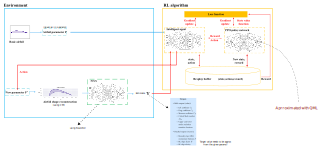

In [2]:
display(SVG(filename="optimprocedure.svg"))

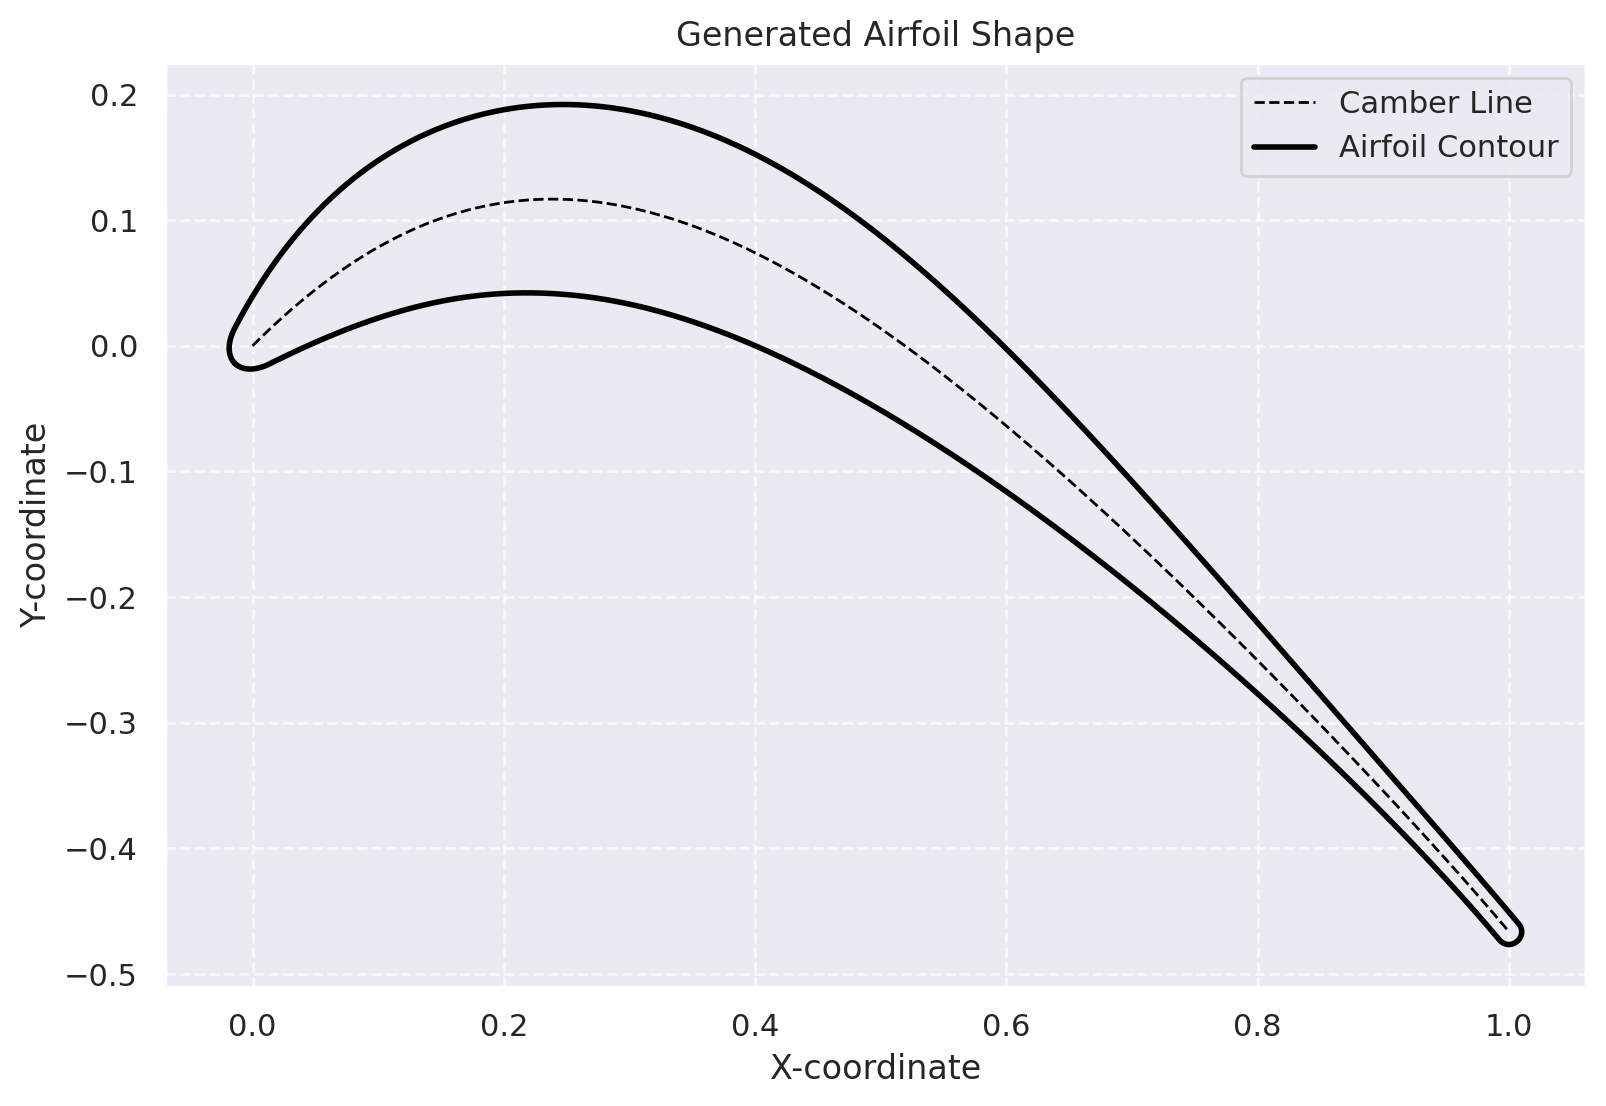

In [3]:
sys.path.append(os.path.abspath("../blade_design_tools"))
import create_airfoil
airfoil_top_points, airfoil_bottom_points, camber_curve_points = create_airfoil.generate_shape(config_filepath="../blade_design_tools/airfoil_config.yaml")

In [4]:
def get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points):
    """
        stacking is up for neurofoil
    """
    # Upper surface: reverse to go from TE to LE
    upper_te_to_le = np.flip(airfoil_top_points, axis=0)

    # Lower surface: LE to TE as is
    lower_le_to_te = airfoil_bottom_points

    # Check if LE points match (for sharp LE); avoid duplicating if so
    if np.allclose(upper_te_to_le[-1], lower_le_to_te[0]):
        coordinates = np.vstack((upper_te_to_le, lower_le_to_te[1:]))
    else:
        coordinates = np.vstack((upper_te_to_le, lower_le_to_te))
    return coordinates


# 7. Export for NeuralFoil
coordinates = get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points)
kulfan_params = get_kulfan_parameters(coordinates)
print("Kulfan parameters:", kulfan_params)

Kulfan parameters: {'lower_weights': array([-0.39463068,  0.5726026 ,  0.17745471,  0.6048875 ,  0.28333585,
        0.40413929,  0.45693178,  0.35682846]), 'upper_weights': array([0.67150686, 0.39899314, 1.0069387 , 0.45522572, 0.61792343,
       0.60628315, 0.35938593, 0.60352649]), 'TE_thickness': 0.01324605086387115, 'leading_edge_weight': 1.103184527384567}


In [5]:
kulfan_airfoil = asb.KulfanAirfoil(name="State p'", **kulfan_params)

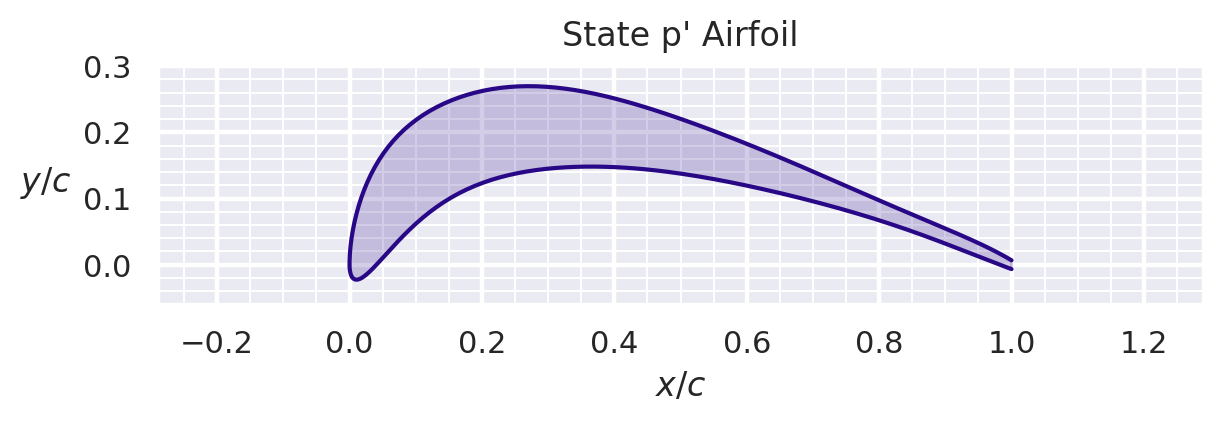

In [6]:
fig, ax = plt.subplots(figsize=(6, 2))
kulfan_airfoil.draw()

In [7]:
initial_guess_airfoil = kulfan_airfoil
opti = asb.Opti()

In [8]:
CL_multipoint_targets = np.array([0.8, 1.0, 1.2, 1.4, 1.5, 1.6])
CL_multipoint_weights = np.array([5, 6, 7, 8, 9, 10])

Re = 500e3 * (CL_multipoint_targets / 1.25) ** -0.5
mach = 0.7

In [9]:
optimized_airfoil = asb.KulfanAirfoil(
    name="Optimized",
    lower_weights=opti.variable(
        init_guess=initial_guess_airfoil.lower_weights,
        lower_bound=-0.5,
        upper_bound=0.25,
    ),
    upper_weights=opti.variable(
        init_guess=initial_guess_airfoil.upper_weights,
        lower_bound=-0.25,
        upper_bound=0.5,
    ),
    leading_edge_weight=opti.variable(
        init_guess=initial_guess_airfoil.leading_edge_weight,
        lower_bound=-1,
        upper_bound=1,
    ),
    TE_thickness=kulfan_params["TE_thickness"],
)

alpha = opti.variable(
    init_guess=45
)

In [10]:
# Why distinguish between aero and optimized airfoil
aero = optimized_airfoil.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=Re,
    mach=mach,
)

# Test optimization frame work
### TODO's: 
- Implement real costfunction
- Shape constraints
- Implement the PPO, here we compare standard PPO vs. Quantum PPO

In [11]:
#Actor -> creates the points: 
#Critic -> rejects them 

opti.subject_to([
    aero["analysis_confidence"] > 0.90,
    aero["CL"] == CL_multipoint_targets,
    np.diff(alpha) > 0,
    aero["CM"] >= -0.133,
    optimized_airfoil.local_thickness(x_over_c=0.33) >= 0.128,
    optimized_airfoil.local_thickness(x_over_c=0.90) >= 0.014,
    optimized_airfoil.TE_angle() >= 6.03, 
    optimized_airfoil.lower_weights[0] < -0.05,
    optimized_airfoil.upper_weights[0] > 0.05,
    optimized_airfoil.local_thickness() > 0
])

get_wiggliness = lambda af: sum([
    np.sum(np.diff(np.diff(array)) ** 2)
    for array in [af.lower_weights, af.upper_weights]
])

opti.subject_to(
    get_wiggliness(optimized_airfoil) < 2 * get_wiggliness(initial_guess_airfoil)
)


# Formulate an optimization goal based
opti.maximize(np.mean(aero["CL"] / aero["CD"]))

sol = opti.solve(
    max_iter = 0,
    behavior_on_failure="return_last",
    options={
       # "ipopt.mu_strategy": 'monotone',
       # "ipopt.start_with_resto": 'yes'
    }
)

optimized_airfoil_0 = sol(optimized_airfoil)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      108
Number of nonzeros in inequality constraint Jacobian.:     2021
Number of nonzeros in Lagrangian Hessian.............:      171

Total number of variables............................:       18
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      153
        inequality constraints with only lower bounds:      134
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       19

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.8561985e-01 9.00e-01 1.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

/home/student.unimelb.edu.au/reissmannm/anaconda3/envs/ode_form/lib/python3.9/site-packages/aerosandbox/optimization/opti.py:728: UserWarning: Optimization failed. Returning last solution.
  warnings.warn("Optimization failed. Returning last solution.")


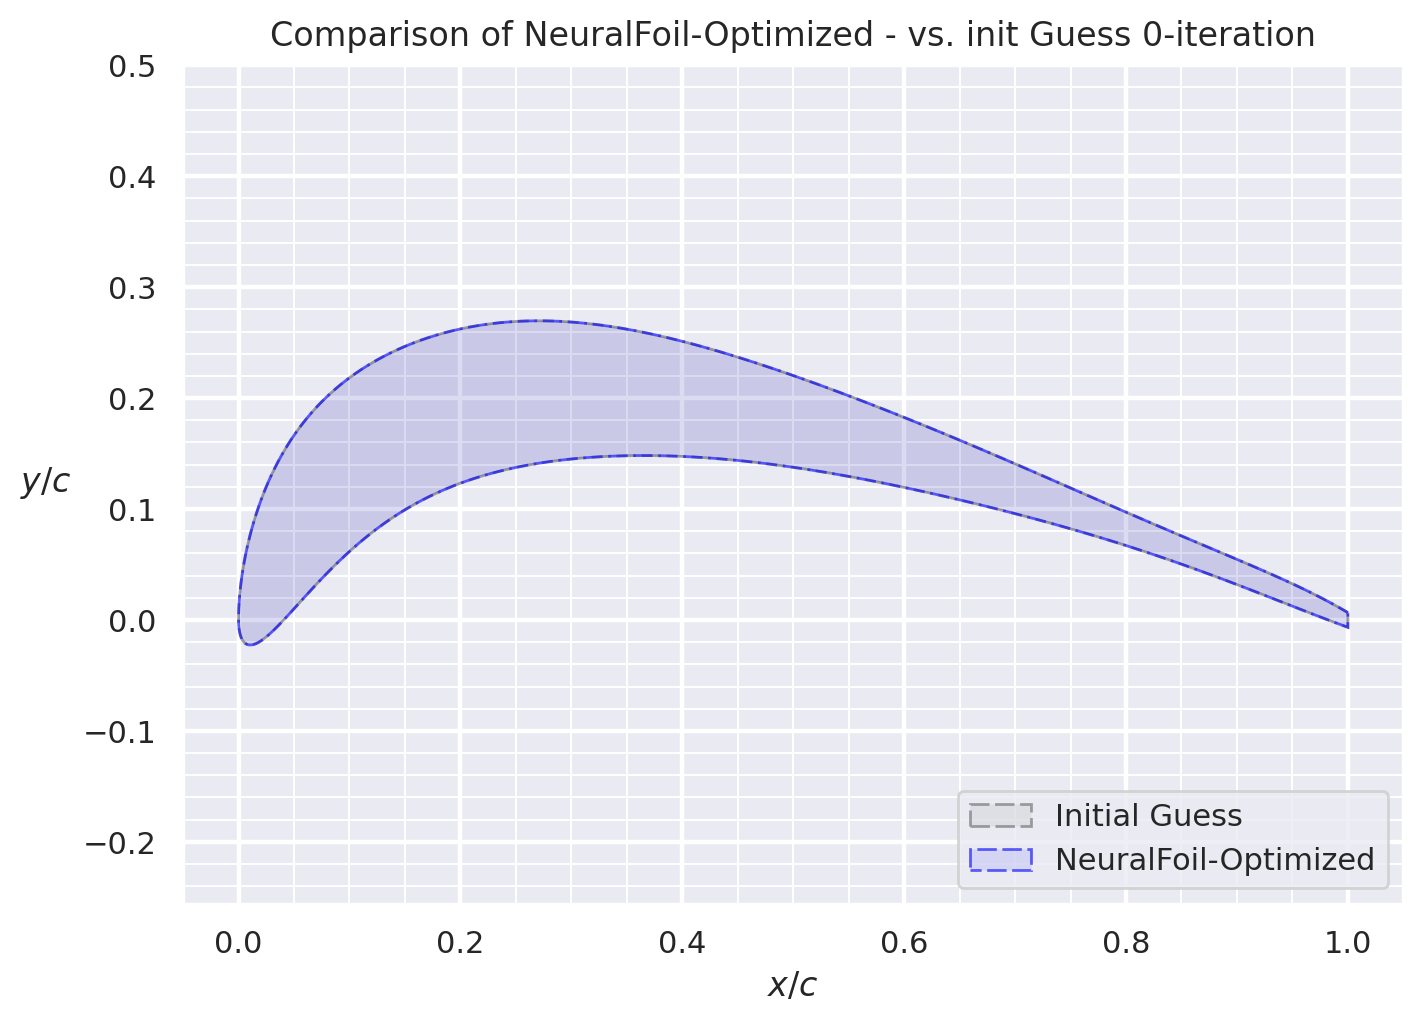

In [12]:
Re_plot = 500e3
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

airfoils_and_colors = {
    "Initial Guess"           : (initial_guess_airfoil, "dimgray"),
    "NeuralFoil-Optimized"    : (optimized_airfoil_0, "blue")}

for i, (name, (af, color)) in enumerate(airfoils_and_colors.items()):
    color = p.adjust_lightness(color, 1)
    ax.fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name,
        linestyle=(3 * i, (7, 2)),
        zorder=4 if "NeuralFoil" in name else 3,
    )

ax.legend(fontsize=11, loc="lower right", ncol=len(airfoils_and_colors)//2)
ax.set_title("Airfoil Shapes")
ax.set_xlabel("$x/c$")
ax.set_ylabel("$y/c$")
ax.axis('equal')

p.show_plot("Comparison of NeuralFoil-Optimized - vs. init Guess 0-iteration", legend=False)

### Interface for NeuralFoil
This provides the values employed for guiding the optimization, here the method call for `get_aero_from_neuralfoil` yields the following values. Question: how to use this parameter to approximate our loss value sought? 

```python
return {
            "analysis_confidence": nf_aero["analysis_confidence"],
            "CL": CL,
            "CD": CD,
            "CM": CM,
            "Cpmin": Cpmin,
            "Top_Xtr": Top_Xtr,
            "Bot_Xtr": Bot_Xtr,
            "mach_crit": mach_crit,
            "mach_dd": mach_dd,
            "Cpmin_0": Cpmin_0,
            **{f"upper_bl_theta_{i}": nf_aero[f"upper_bl_theta_{i}"] for i in range(N)},
            **{f"upper_bl_H_{i}": nf_aero[f"upper_bl_H_{i}"] for i in range(N)},
            **{
                f"upper_bl_ue/vinf_{i}": nf_aero[f"upper_bl_ue/vinf_{i}"]
                for i in range(N)
            },
            **{f"lower_bl_theta_{i}": nf_aero[f"lower_bl_theta_{i}"] for i in range(N)},
            **{f"lower_bl_H_{i}": nf_aero[f"lower_bl_H_{i}"] for i in range(N)},
            **{
                f"lower_bl_ue/vinf_{i}": nf_aero[f"lower_bl_ue/vinf_{i}"]
                for i in range(N)
            },
        }
```

Hint the returns values such as CL are wrapped into Casadi type. Therefore we need to employ solve to evaluate the AD graph. 

In [13]:
# Having a look for aero at the start: -> needs to be validated agains the expeced ones
resolved_values_0 = sol(aero)

In [14]:
#Lets perfom for 500 iterations:

In [ ]:
sol_2 = opti.solve(
    max_iter = 1000,
    behavior_on_failure="return_last",
    options={
       # "ipopt.mu_strategy": 'monotone',
       # "ipopt.start_with_resto": 'yes'
    }
)

optimized_airfoil_1000 = sol_2(optimized_airfoil)
resolved_values_1000 = sol_2(aero)

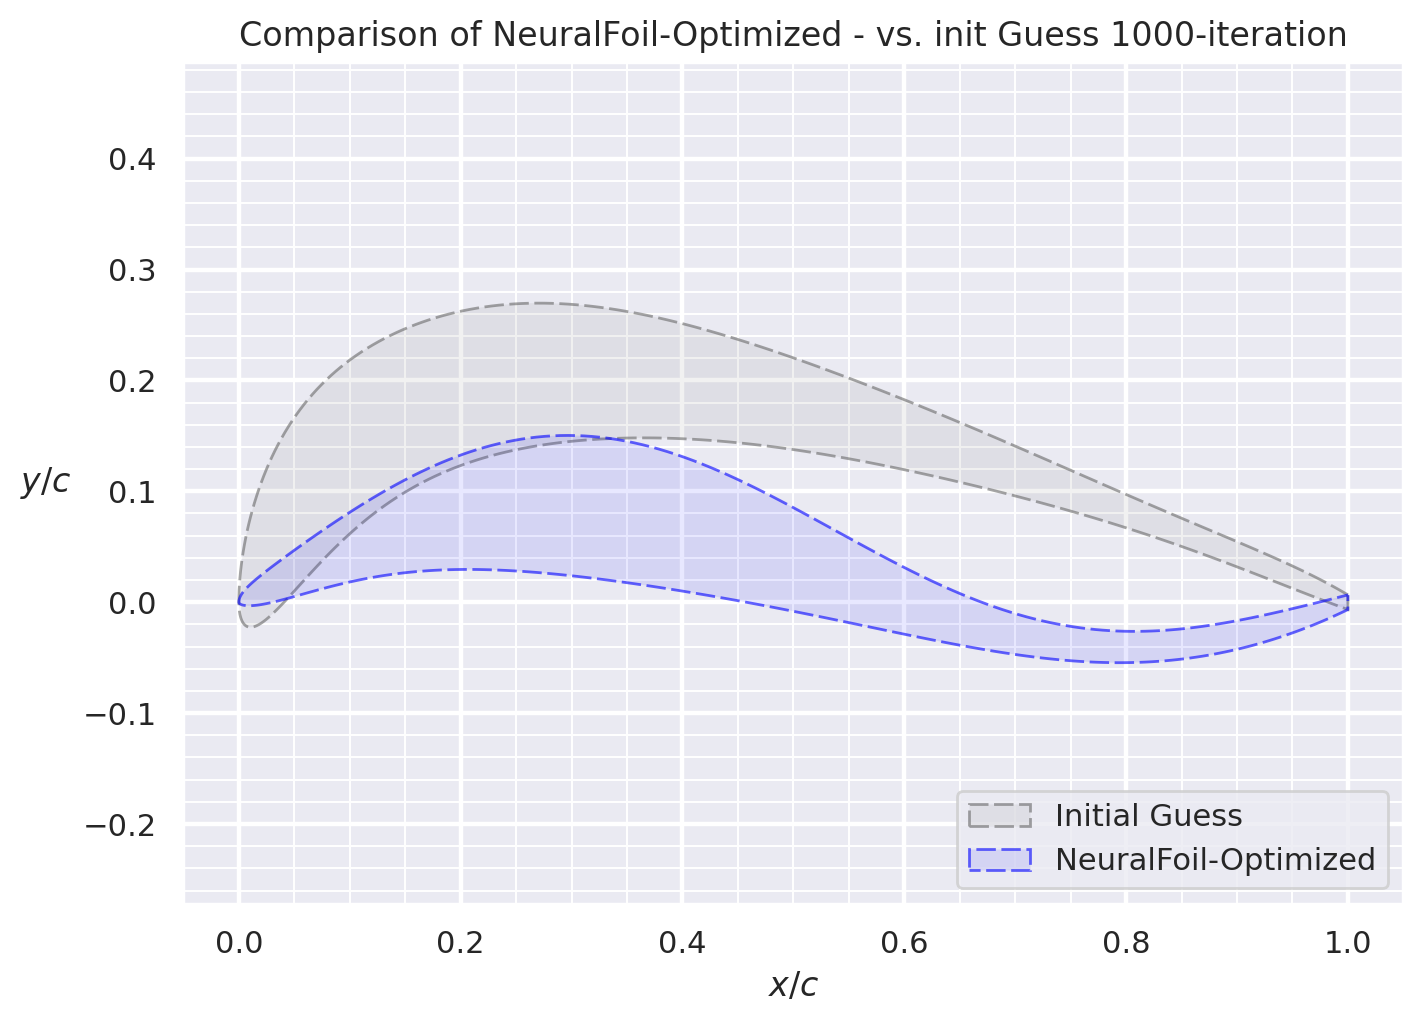

In [23]:
Re_plot = 500e3
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

airfoils_and_colors = {
    "Initial Guess"           : (initial_guess_airfoil, "dimgray"),
    "NeuralFoil-Optimized"    : (optimized_airfoil_1000, "blue")}

for i, (name, (af, color)) in enumerate(airfoils_and_colors.items()):
    color = p.adjust_lightness(color, 1)
    ax.fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name,
        linestyle=(3 * i, (7, 2)),
        zorder=4 if "NeuralFoil" in name else 3,
    )

ax.legend(fontsize=11, loc="lower right", ncol=len(airfoils_and_colors)//2)
ax.set_title("Airfoil Shapes")
ax.set_xlabel("$x/c$")
ax.set_ylabel("$y/c$")
ax.axis('equal')

p.show_plot("Comparison of NeuralFoil-Optimized - vs. init Guess 1000-iteration", legend=False)

In [20]:
print(f"CD at 0 for the points: {resolved_values_0['CD']}")
print(f"CL at 0 for the points: {resolved_values_0['CL']}")

print(f"CD at 1000 for the points: {resolved_values_1000['CD']}")
print(f"CL at 1000 for the points: {resolved_values_1000['CL']}")

CD at 0 for the points: [1.27813715 1.2782529  1.2783494  1.27843238 1.27846993 1.2785053 ]
CL at 0 for the points: [0.74863172 0.74863172 0.74863172 0.74863172 0.74863172 0.74863172]
CD at 1000 for the points: [0.72260566 0.72272036 0.72281521 0.72289668 0.72293343 0.72296783]
CL at 1000 for the points: [0.71851814 0.71853353 0.71854181 0.71854293 0.718542   0.71854087]
